In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

import sys
import os
from  tensorflow import keras 
sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:

train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,None,include_targets=False,num_outputs = 10)

targetsis : False
trainSize 45000
testSize 10000


In [8]:
# Model / data parameters
num_classes = 100
batch_size = 32
input_shape = (32, 32, 1)
(x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
print(x_train100.shape)
# convert class vectors to binary class matrices
y_train100 = keras.utils.to_categorical(y_train100, num_classes)
y_test100 = keras.utils.to_categorical(y_test100, num_classes)
    
train_ds100 = tf.data.Dataset.from_tensor_slices((x_train100, y_train100))
test_ds100 = tf.data.Dataset.from_tensor_slices((x_test100, y_test100))
train_ds100 = (train_ds100
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds100 = (test_ds100
                .batch(batch_size=batch_size, drop_remainder=True))
print(train_ds100)



(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32, 100), dtype=tf.float32, name=None))>


In [9]:
# # Model / data parameters
# num_classes = 100
# input_shape = (32, 32, 1)
# (x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

# # convert class vectors to binary class matrices
# y_train100 = keras.utils.to_categorical(y_train100, num_classes)
# y_test100 = keras.utils.to_categorical(y_test100, num_classes)


In [10]:
def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl


class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32)
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def loss_wrapper(lambda_callback: lambda_update):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function




In [10]:
# model = keras.models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10))
# model.save("./models/cifaroutlier_blank.hdf5")


In [11]:
# model = tf.keras.models.Sequential()
# from keras import layers
# model.add(keras.Input(shape=(32,32,3)))
# model.add(layers.Conv2D(32, 5, activation='tanh'))
# model.add(layers.AveragePooling2D(2))
# model.add(layers.Activation('sigmoid'))
# model.add(layers.Conv2D(192, 5, activation='tanh'))
# model.add(layers.AveragePooling2D(2))
# model.add(layers.Activation('sigmoid'))
# model.add(layers.Conv2D(192, 5, activation='tanh'))
# model.add(layers.Flatten())
# model.add(layers.Dense(1000, activation='tanh'))
# model.add(layers.Dense(10, activation='softmax'))

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def CE(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels, m)
        annealing_rate =  lambda_callback.lambda_t
        C =  annealing_rate * KL(alp,10)
        #A = annealing_rate * A
        return loss + A +  C
        # return (A + B) + C
    return  cross_entropy_evidence

def MAEBM():
    def loss(labels, outputs):
        evidence =exp_evidence(outputs) #activation function
        # evidence = exp_evidence(outputs)
        # alpha = evidence + 1
        alpha = evidence + 1
        S = tf.reduce_sum(alpha)
        # tf.print(S)
        alpha_0 = tf.fill(alpha.shape,S)
        # tf.print(alpha)
        UCE_loss = tf.reduce_mean(labels * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha)))
        UCE_loss  +=  0.0001  * (tf.reduce_sum(tf.compat.v1.lgamma(alpha)) - tf.compat.v1.lgamma(S) -
                (len(alpha) - S) * tf.compat.v1.digamma(S) -
                ((alpha - 1.0) * tf.reduce_sum(tf.compat.v1.digamma(alpha))))
        # tf.print(UCE_loss)
        return UCE_loss
    return loss 

def entropyMetric():
    def entropy(p, logits):
        #METRIC OF THE mean of uncertainity
        evidence =exp_evidence(logits)
        alpha = evidence +1
        S = tf.reduce_sum(alpha)
        Mass = alpha / S
        u = num_classes / S
        return (tf.reduce_mean(u)) # Note the `axis=-1`
    return entropy

In [14]:

def entropyMetric():
    def entropy(p, logits):
        #METRIC OF THE mean of uncertainity
        evidence =exp_evidence(logits)
        alpha = evidence +1
        S = tf.reduce_sum(alpha)
        Mass = alpha / S
        u = num_classes / S
        return (tf.reduce_mean(u)) # Note the `axis=-1`
    return entropy

lambda_callback = lambda_update(100)
loss = CE(lambda_callback)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss_wrapper(lambda_callback),
              metrics=['accuracy',entropyMetric()])

history = model.fit(train_ds, epochs=10,callbacks=[lambda_callback])

annealing coef updated to: 0
Epoch 1/10
1406/1406 [==============================] - 9s 6ms/step - loss: 0.7109 - accuracy: 0.4178 - entropy: 0.0124
annealing coef updated to: 0.01
Epoch 2/10
1406/1406 [==============================] - 8s 6ms/step - loss: 0.6452 - accuracy: 0.5677 - entropy: 0.0230
annealing coef updated to: 0.02
Epoch 3/10
1406/1406 [==============================] - 8s 6ms/step - loss: 0.6111 - accuracy: 0.6118 - entropy: 0.0192
annealing coef updated to: 0.03
Epoch 4/10
1406/1406 [==============================] - 8s 6ms/step - loss: 0.5876 - accuracy: 0.6410 - entropy: 0.0128
annealing coef updated to: 0.04
Epoch 5/10
1406/1406 [==============================] - 8s 6ms/step - loss: 0.5633 - accuracy: 0.6671 - entropy: 0.0083
annealing coef updated to: 0.05
Epoch 6/10
1406/1406 [==============================] - 8s 6ms/step - loss: 0.5512 - accuracy: 0.6843 - entropy: 0.0054
annealing coef updated to: 0.06
Epoch 7/10
1406/1406 [==============================] - 8s 

In [15]:
model.save('./models/cifaroutlier_EDL_an100.hdf5')

In [18]:
import numpy as np
import sys
import os
import pickle
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as trn
import torchvision.datasets as dset
import torch.nn.functional as F
from models.wrn import WideResNet
from skimage.filters import gaussian as gblur
from PIL import Image as PILImage


# /////////////// Detection Prelims ///////////////

ood_num_examples = len(test_data) // 5
expected_ap = ood_num_examples / (ood_num_examples + len(test_data))

concat = lambda x: np.concatenate(x, axis=0)
to_np = lambda x: x.data.cpu().numpy()


def get_ood_scores(input_set, in_dist=False,stopping_point = None):
    _score = []
    _right_score = []
    _wrong_score = []

    with torch.no_grad():
        # for batch_idx, (data, target) in enumerate(loader):
            # if batch_idx >= ood_num_examples // args.test_bs and in_dist is False:
                # break
        for i, (x,y) in enumerate(input_set):
            if stopping_point and i > stopping_point:
                break
            print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
            output = model.predict(x)

            # data = data.cuda()

            # output = net(data)
            
            
            smax = to_np(F.softmax(output, dim=1))

            if args.use_xent:
                _score.append(to_np((output.mean(1) - torch.logsumexp(output, dim=1))))
            else:
                if args.score == 'energy':
                    _score.append(-to_np((args.T*torch.logsumexp(output / args.T, dim=1))))
                else: # original MSP and Mahalanobis (but Mahalanobis won't need this returned)
                    _score.append(-np.max(smax, axis=1))

            if in_dist:
                preds = np.argmax(smax, axis=1)
                targets = target.numpy().squeeze()
                right_indices = preds == targets
                wrong_indices = np.invert(right_indices)

                if args.use_xent:
                    _right_score.append(to_np((output.mean(1) - torch.logsumexp(output, dim=1)))[right_indices])
                    _wrong_score.append(to_np((output.mean(1) - torch.logsumexp(output, dim=1)))[wrong_indices])
                else:
                    _right_score.append(-np.max(smax[right_indices], axis=1))
                    _wrong_score.append(-np.max(smax[wrong_indices], axis=1))

    if in_dist:
        return concat(_score).copy(), concat(_right_score).copy(), concat(_wrong_score).copy()
    else:
        return concat(_score)[:ood_num_examples].copy()

OSError: [WinError 127] The specified procedure could not be found. Error loading "C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\torch\lib\cudnn_adv_infer64_8.dll" or one of its dependencies.

In [ ]:
in_score, right_score, wrong_score = get_ood_scores(test_ds, in_dist=True)

In [79]:
### MA-EBM OOD detection

import numpy as np
from scipy.special import gammaln, digamma
import tensorflow as tf

def dirichlet_prior_network_uncertainty(logits, epsilon=1e-10, alpha_correction=True):
    """
    :param logits:
    :param epsilon:
    :return:
    """
    logits = np.asarray(logits, dtype=np.float64)
    alphas = np.exp(logits)

    alphas = np.clip(alphas, 0, np.finfo(np.dtype("float32")).max)

    if alpha_correction:
        alphas = alphas + 1

    alpha0 = np.sum(alphas, axis=1, keepdims=True)
    probs = alphas / alpha0

    conf = np.max(probs, axis=1)

    entropy_of_exp = -np.sum(probs * np.log(probs + epsilon), axis=1)
    expected_entropy = -np.sum(
        (alphas / alpha0) * (digamma(alphas + 1) - digamma(alpha0 + 1.0)), axis=1
    )

    mutual_info = entropy_of_exp - expected_entropy

    epkl = np.squeeze((alphas.shape[1] - 1.0) / alpha0)

    dentropy = (
        np.sum(
            gammaln(alphas) - (alphas - 1.0) * (digamma(alphas) - digamma(alpha0)),
            axis=1,
            keepdims=True,
        )
        - gammaln(alpha0)
    )

    uncertainty = {
        "confidence_alea_uncert.": conf,
        "entropy_of_expected": -entropy_of_exp,
        "expected_entropy": -expected_entropy,
        "mutual_information": -mutual_info,
        "EPKL": -epkl,
        "differential_entropy": -np.squeeze(dentropy),
    }
    results = {}
    
    for k,v in uncertainty.items():
            results[k] =v.mean()
    # k: torch.from_numpy(v).float() for k, v in uncertainty.items()
    results["p(x)"] = tf.math.reduce_logsumexp(tf.cast(logits,tf.float32)).numpy()
    results["max p(y|x)"] = np.amax(tf.nn.softmax(tf.cast(logits,tf.float32)))

    return results
# dirichlet_prior_network_uncertainty([[1,1,1,1,1,1,1,1,1,1]])
logits = [[1,1,1,1,1,1,1,1,1,1]]
dir_uncert = dirichlet_prior_network_uncertainty(logits)
print(dir_uncert)

{'confidence_alea_uncert.': 0.09999999999999999, 'entropy_of_expected': -2.302585091994046, 'expected_entropy': -2.1874864443604523, 'mutual_information': -0.11509864763359356, 'EPKL': -0.2420472792329956, 'differential_entropy': 15.84162062462957, 'p(x)': 3.3025851, 'max p(y|x)': 0.1}


In [80]:
#next, do the outlier comparasion test for the energy model and make a graph for each of these values.
import math
num_classes=10
def getPredictions_energy(model, input_set, stopping_point = None):
    # stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Dir_U = []
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            dir_uncert = dirichlet_prior_network_uncertainty(np.array([prediction]))
            Dir_U.append(dir_uncert)
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    energy_uncert = pd.DataFrame(Dir_U)
    # print(energy_uncert)
    df = pd.DataFrame({"x":Results,"y":Labels})
    df = pd.concat([df,energy_uncert],axis=1,join="inner")
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))



In [ ]:

outputs_test = getPredictions_energy(model,test_ds)
print(outputs_test)
        
outputs100 = getPredictions_energy(model,test_ds100)
print(outputs100)


[]ediction: 311 of 312
avg entropy nan


C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.
C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


      x  y  confidence_alea_uncert.  entropy_of_expected  expected_entropy  \
0     8  3                 0.814705            -0.482196         -0.482049   
1     8  8                 0.999999            -0.000019         -0.000019   
2     0  8                 0.525802            -0.693304         -0.693240   
3     0  0                 0.999313            -0.005692         -0.005692   
4     6  6                 0.990790            -0.055615         -0.055382   
...  .. ..                      ...                  ...               ...   
9979  5  3                 0.718007            -0.610635         -0.609681   
9980  0  0                 0.964415            -0.154899         -0.154828   
9981  7  4                 0.998228            -0.014470         -0.014319   
9982  4  2                 0.999989            -0.000162         -0.000158   
9983  1  0                 1.000000            -0.000004         -0.000004   

      mutual_information          EPKL  differential_entropy   

In [77]:
def buildOutlierPlot_energy(ID,OOD,threshold=None):
    for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        # plt.title("Histogram with 'auto' bins")
        plt.title(k)
        plt.legend(["In distribution","Out of Distribution"])
        plt.xlabel("entropy")
        plt.ylabel("frequency")
        plt.show()
        # print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
        # print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
        # Correct = ID.loc[(ID['correct'] == True)]
        # Incorrect = ID.loc[(ID['correct'] == False)]
        # print("overall acc on ID:",len(Correct)/len(ID))
    
# buildOutlierPlot_energy(outputs_test, outputs100, None)

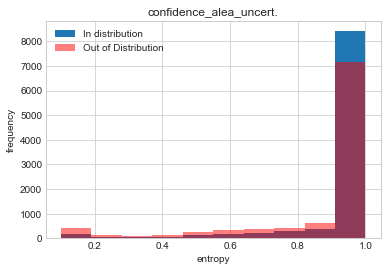

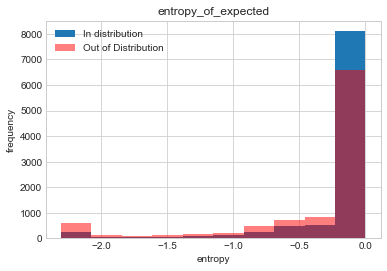

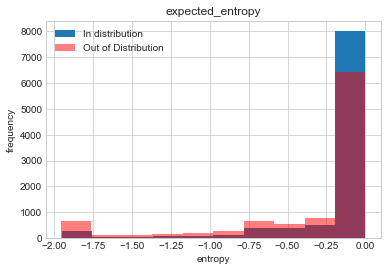

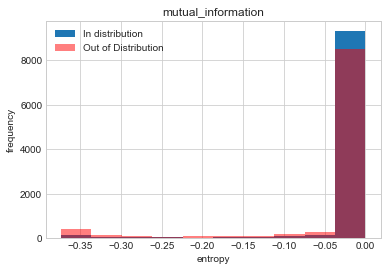

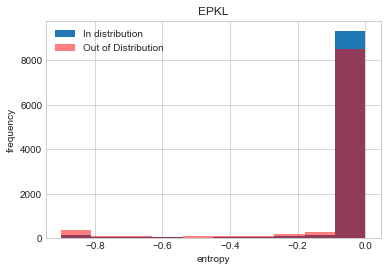

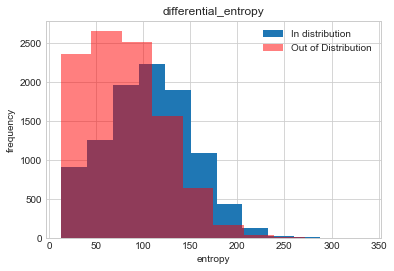

In [78]:
buildOutlierPlot_energy(outputs_test,outputs100)

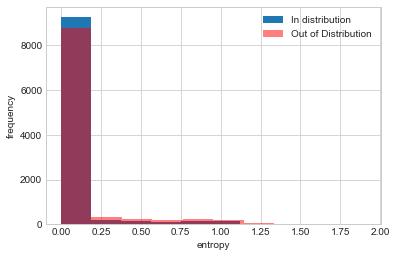

OOD accepted with avg ID entropy threshold of  0.051234607 :  8231 out of  9984
ID accepted with avg ID entropy threshold of  0.051234607 :  8968 out of  9984 with acc of  0.6952497769848349
overall acc on ID: 0.65625


In [172]:
buildOutlierPlot(outputs_test, outputs100, 0.051234607)

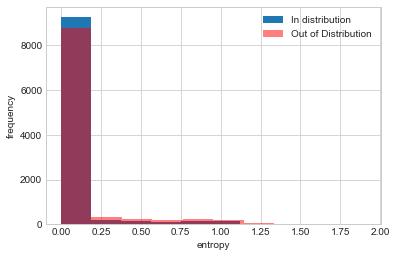

OOD accepted with avg ID entropy threshold of  0.4392441 :  9156 out of  9984
ID accepted with avg ID entropy threshold of  0.4392441 :  9494 out of  9984 with acc of  0.6754792500526648
overall acc on ID: 0.65625


(50000, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(32, 100), dtype=tf.float32, name=None))>


In [129]:
import math
num_classes=10
def getPredictions(model, input_set):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            evidence =exp_evidence(prediction)
            alpha = evidence +1
            S = sum(alpha)
            E = alpha - 1
            Mass = alpha / S
            u = num_classes / S
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))



[0.9289042  0.5010212  0.85671026 ... 0.23634537 0.8410823  0.53505623]
avg entropy 0.4392441
      x  y    uncert correct
0     3  3  0.928904       1
1     1  8  0.501021       0
2     1  8  0.856710       0
3     0  0  0.904850       1
4     4  6  0.093025       0
...  .. ..       ...     ...
9979  3  3  0.862676       1
9980  8  0  0.966392       0
9981  4  4  0.236345       1
9982  6  2  0.841082       0
9983  1  0  0.535056       0

[9984 rows x 4 columns]


In [110]:
outputs = getPredictions(model,test_ds)
print(outputs)
# avg entropy 0.43924412

avg entropy 4.39244132
      x  y    uncert correct
0     3  3  9.289042       1
1     1  8  5.010212       0
2     1  8  8.567102       0
3     0  0  9.048504       1
4     4  6  0.930254       0
...  .. ..       ...     ...
9979  3  3  8.626763       1
9980  8  0  9.663918       0
9981  4  4  2.363454       1
9982  6  2  8.410823       0
9983  1  0  5.350562       0

[9984 rows x 4 columns]


      x  y    uncert correct
4     4  6  0.930254       0
5     5  6  3.623051       0
6     9  1  1.296380       0
7     6  6  2.699459       1
11    9  9  0.004538       1
...  .. ..       ...     ...
9975  7  7  0.004538       1
9976  5  5  0.979602       1
9977  5  5  0.282922       1
9978  4  7  0.796550       0
9981  4  4  2.363454       1

[5065 rows x 4 columns]
      x  y    uncert correct
0     3  3  9.289042       1
3     0  0  9.048504       1
7     6  6  2.699459       1
8     3  3  7.678715       1
9     1  1  6.884835       1
...  .. ..       ...     ...
9975  7  7  0.004538       1
9976  5  5  0.979602       1
9977  5  5  0.282922       1
9979  3  3  8.626763       1
9981  4  4  2.363454       1

[6483 rows x 4 columns]


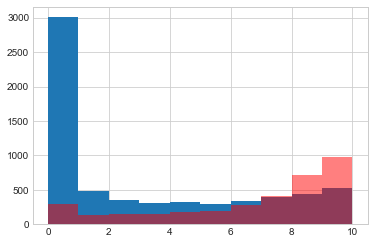

In [117]:
threshold = 4.39244132
accepted = outputs.loc[(outputs['uncert'] <= threshold)]
print(accepted)

import matplotlib.pyplot as plt
Correct = outputs.loc[(outputs['correct'] == True)]
Incorrect = outputs.loc[(outputs['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

In [130]:

outputs100 = getPredictions(model,test_ds100)
print(outputs100)

[0.23711371 0.67648697 0.85404116 ... 0.7878681  0.66152674 0.10553702]
avg entropy 0.66300267
      x   y    uncert correct
0     0  49  0.237114       0
1     4  33  0.676487       0
2     4  72  0.854041       0
3     1  51  0.115120       0
4     1  71  0.842340       0
...  ..  ..       ...     ...
9979  3  27  0.366997       0
9980  8  30  0.636400       0
9981  9  52  0.787868       0
9982  6  74  0.661527       0
9983  6  29  0.105537       0

[9984 rows x 4 columns]


      x   y    uncert correct
0     0  49  0.237114       0
3     1  51  0.115120       0
6     4  15  0.370688       0
9     7   0  0.156786       0
10    3  71  0.411594       0
...  ..  ..       ...     ...
9970  6  18  0.008494       0
9972  8  26  0.239801       0
9974  8  11  0.308005       0
9979  3  27  0.366997       0
9983  6  29  0.105537       0

[2403 rows x 4 columns]
      x  y    uncert correct
200   6  6  0.887254       1
267   1  1  0.786784       1
268   6  6  0.806364       1
476   8  8  0.453028       1
648   7  7  0.866996       1
...  .. ..       ...     ...
9524  1  1  0.681051       1
9853  4  4  0.495359       1
9857  9  9  0.902897       1
9874  7  7  0.935731       1
9945  4  4  0.835873       1

[84 rows x 4 columns]


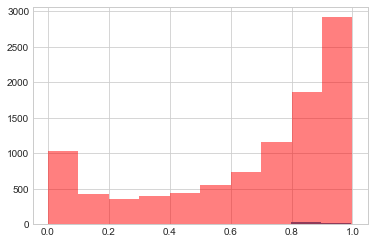

In [131]:
threshold = 0.4392441
accepted = outputs100.loc[(outputs100['uncert'] <= threshold)]
print(accepted)

import matplotlib.pyplot as plt
Correct = outputs100.loc[(outputs100['correct'] == True)]
Incorrect = outputs100.loc[(outputs100['correct'] == False)]
print(Correct)
_ = plt.hist(Correct['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
_ = plt.hist(Incorrect['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

      x  y    uncert correct
200   6  6  0.887254       1
267   1  1  0.786784       1
268   6  6  0.806364       1
476   8  8  0.453028       1
648   7  7  0.866996       1
...  .. ..       ...     ...
9524  1  1  0.681051       1
9853  4  4  0.495359       1
9857  9  9  0.902897       1
9874  7  7  0.935731       1
9945  4  4  0.835873       1

[84 rows x 4 columns]


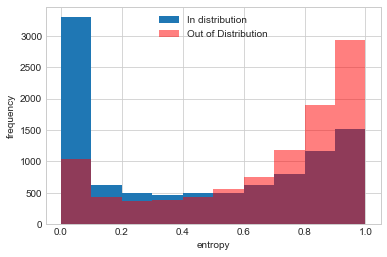

OOD accepted with avg ID entropy threshold of  0.4392441 :  2403 out of  9984
ID accepted with avg ID entropy threshold of  0.4392441 :  5065 out of  9984 with acc of  0.8452122408687068


In [140]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs_test, outputs100, 0.4392441)

In [142]:
Correct = outputs_test.loc[(outputs_test['correct'] == True)]
Incorrect = outputs_test.loc[(outputs_test['correct'] == False)]
print(len(Correct)/len(outputs_test))

0.6493389423076923


In [152]:
def entropyMetric_old():
    def entropy(p, y_hat):
        #METRIC OF THE mean of uncertainity
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies
    return entropy

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric_old()])

history = model.fit(train_ds, epochs=10)

Epoch 1/10
1406/1406 [==============================] - 7s 4ms/step - loss: 1.7714 - accuracy: 0.3800 - entropy: -269.5092
Epoch 2/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.3332 - accuracy: 0.5236 - entropy: -547.2267
Epoch 3/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.1859 - accuracy: 0.5852 - entropy: -793.7892
Epoch 4/10
1406/1406 [==============================] - 6s 4ms/step - loss: 1.0911 - accuracy: 0.6173 - entropy: -1051.1556
Epoch 5/10
1406/1406 [==============================] - 6s 5ms/step - loss: 1.0100 - accuracy: 0.6464 - entropy: -1337.5408
Epoch 6/10
1406/1406 [==============================] - 7s 5ms/step - loss: 0.9382 - accuracy: 0.6712 - entropy: -1744.2469
Epoch 7/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8893 - accuracy: 0.6900 - entropy: -2221.8240
Epoch 8/10
1406/1406 [==============================] - 6s 4ms/step - loss: 0.8389 - accuracy: 0.7068 - entropy: -2834.1406
Epoch 9/10


In [155]:
import math
num_classes=10
def getPredictions(model, input_set):
    stopping_point = None
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    pAcc=[]
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        print("prediction: {} of {}".format(i,len(test_ds)),end='\r')
        predictions = model.predict(x)
        for j, prediction in enumerate(predictions):
            y_hat =tf.nn.softmax(prediction)
            val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
            u =  -tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
            Uncert.append(u.numpy().mean())
            Results.append(np.argmax(prediction))
            Labels.append(np.argmax(y[j]))
    _uncert = np.array(Uncert)
    print(_uncert)
    print("avg entropy",_uncert.mean())
    df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert})
    conditions = [df['x'] == df['y'],df['x'] != df['y']]
    choices = [1, 0]
    df['correct'] = np.select(conditions, choices, default=None)
    return df

outputs_test2 = getPredictions(model,test_ds)
print(outputs_test2)
# Correct = outputs.loc[(outputs['correct'] == True)].groupby("correct")["uncert"].mean().iloc[0]
# Incorrect = outputs.loc[(outputs['correct'] == False)].groupby("correct")["uncert"].mean().iloc[0]
# print("Correct", Correct, "incorrect", Incorrect)
# print("overallAcc", len(outputs.loc[(outputs['correct'] == True)])/len(outputs))
model.evaluate(test_ds)


[2.9127266  0.28847754 1.7646978  ... 1.5443833  2.1113863  0.4810803 ]
avg entropy 1.0540112
      x  y    uncert correct
0     8  3  2.912727       0
1     8  8  0.288478       1
2     0  8  1.764698       0
3     0  0  0.412173       1
4     6  6  1.835032       1
...  .. ..       ...     ...
9979  3  3  0.222059       1
9980  0  0  0.102112       1
9981  7  4  1.544383       0
9982  3  2  2.111386       0
9983  1  0  0.481080       0

[9984 rows x 4 columns]


In [156]:
outputs100_2 = getPredictions(model,test_ds100)
print(outputs100_2)

[0.7781605 2.2761638 1.5880288 ... 0.7205749 2.28415   1.5985643]
avg entropy 1.5279474
      x   y    uncert correct
0     2  49  0.778161       0
1     4  33  2.276164       0
2     0  72  1.588029       0
3     9  51  1.273938       0
4     8  71  2.651380       0
...  ..  ..       ...     ...
9979  2  27  0.562674       0
9980  0  30  1.932048       0
9981  7  52  0.720575       0
9982  5  74  2.284150       0
9983  2  29  1.598564       0

[9984 rows x 4 columns]


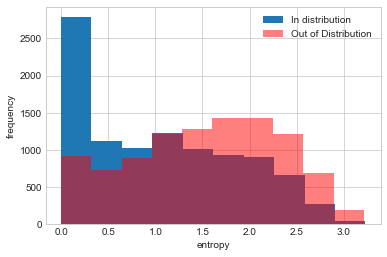

OOD accepted with avg ID entropy threshold of  1.5279474 :  4726 out of  9984
ID accepted with avg ID entropy threshold of  1.5279474 :  6876 out of  9984 with acc of  0.7232402559627691
overall acc on ID: 0.6126802884615384


In [161]:
def buildOutlierPlot(ID,OOD,threshold):
    _ = plt.hist(ID['uncert'].tolist(), bins=10)  # arguments are passed to np.histogram
    _ = plt.hist(OOD['uncert'].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
    # plt.title("Histogram with 'auto' bins")
    plt.legend(["In distribution","Out of Distribution"])
    plt.xlabel("entropy")
    plt.ylabel("frequency")
    plt.show()
    print("OOD accepted with avg ID entropy threshold of ",threshold, ": ", len(OOD.loc[(OOD['uncert'] <= threshold)]), "out of ", len(OOD))
    print("ID accepted with avg ID entropy threshold of ",threshold, ": ", len(ID.loc[(ID['uncert'] <= threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID['uncert'] <= threshold) & ID['correct'] == True])/len(ID.loc[(ID['uncert'] <= threshold)]))
    Correct = ID.loc[(ID['correct'] == True)]
    Incorrect = ID.loc[(ID['correct'] == False)]
    print("overall acc on ID:",len(Correct)/len(ID))
    
buildOutlierPlot(outputs_test2, outputs100_2, 1.5279474)

In [165]:
def MAEBM(annealing):
    def loss(labels, outputs):
        # tf.print(outputs)
        evidence = tf.exp(outputs) #activation function
        # tf.print(evidence)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha)
        # tf.print(S)
        alpha_0 = tf.fill(alpha.shape,S)
        UCE_loss = tf.reduce_mean(labels * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha)))
        # print("loss_1",UCE_loss)
        
        
        UCE_loss  +=  0.0001  * (tf.reduce_sum(tf.compat.v1.lgamma(alpha)) - tf.compat.v1.lgamma(S) -
                (len(alpha) - S) * tf.compat.v1.digamma(S) -
                ((alpha - 1.0) * tf.reduce_sum(tf.compat.v1.digamma(alpha))))
        # tf.print(UCE_loss)
        return UCE_loss
    return loss 
def entropyMetric():
    def entropy(p, logits):
        #METRIC OF THE mean of uncertainity
        evidence =exp_evidence(logits)
        alpha = evidence +1
        S = tf.reduce_sum(alpha)
        Mass = alpha / S
        u = num_classes / S
        return (tf.reduce_mean(u)) # Note the `axis=-1`
    return entropy

lambda_callback = lambda_update(100)
loss = MAEBM(lambda_callback)
model = keras.models.load_model("./models/cifaroutlier_blank.hdf5")
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy',entropyMetric()])

history = model.fit(train_ds, epochs=10,callbacks=[lambda_callback])


annealing coef updated to: 0
Epoch 1/10
 753/1406 [===============>..............] - ETA: 3s - loss: nan - accuracy: 0.1011 - entropy: nan

KeyboardInterrupt: 